In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback
from npm3dGenerator_tree import NPM3DGenerator, NPM3DGenerator_full
from models import build_point_net, save_model, load_model
import utils_training as u_t

Using TensorFlow backend.


In [2]:
training_dataset = NPM3DGenerator(paths_to_keep = [0, 1, 2], sample_uniformly_from_classes = True)
validation_dataset = NPM3DGenerator(paths_to_keep = [0], sample_uniformly_from_classes = True)
print(training_dataset)

not path is None ../Benchmark_MVA/training\MiniLille1.ply
../Benchmark_MVA/training\MiniLille1_normals.npy
else ../Benchmark_MVA/training\MiniLille1_normals.npy
not path is None ../Benchmark_MVA/training\MiniLille2.ply
../Benchmark_MVA/training\MiniLille2_normals.npy
else ../Benchmark_MVA/training\MiniLille2_normals.npy
not path is None ../Benchmark_MVA/training\MiniParis1.ply
../Benchmark_MVA/training\MiniParis1_normals.npy
else ../Benchmark_MVA/training\MiniParis1_normals.npy



not path is None ../Benchmark_MVA/training\MiniLille1.ply
../Benchmark_MVA/training\MiniLille1_normals.npy
else ../Benchmark_MVA/training\MiniLille1_normals.npy

NPM3DGenerator config
n_classes         : 6
batch_size        : 8
n_points          : 4096
n_channels        : 8
train             : True
use_normals       : True
normal_radius     : 0.75
compute_normals   : True
class_weight      : [2.81 2.91 197.21 264.28 32.82 4.70]


In [3]:
miou_metric = u_t.mIoU(training_dataset.n_classes)

#model = build_point_net(input_shape = (training_dataset.n_points, training_dataset.n_channels), output_shape = training_dataset.n_classes)
model = load_model("trained_{}_{}_{}".format(training_dataset.n_points, training_dataset.n_channels, training_dataset.n_classes))
model.compile("adam", u_t.my_categorical_crossentropy, metrics = ["accuracy", miou_metric.miou])
#model.summary()

Loaded model from disk


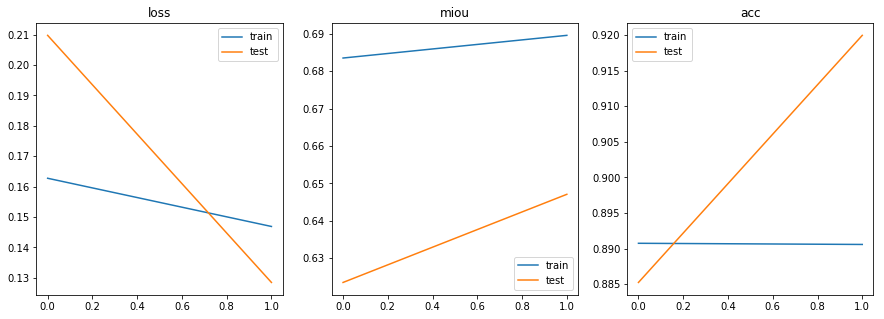

In [8]:
n_epochs = 2
history = model.fit_generator(training_dataset, epochs = n_epochs,
                              validation_data = validation_dataset,
                              class_weight = training_dataset.class_weight,
                              verbose = 0, callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
u_t.plot_history(history)

In [9]:
save_model(model, "trained_{}_{}_{}_2x10epochs_plus_4epochs_uniform_sample".format(training_dataset.n_points, training_dataset.n_channels, training_dataset.n_classes))

Saved model to disk


not path is None ../Benchmark_MVA/test\MiniDijon9.ply
../Benchmark_MVA/test\MiniDijon9_normals.npy
else ../Benchmark_MVA/test\MiniDijon9_normals.npy



(array([1334772.,       0., 1262193.,       0.,   15959.,       0.,
           8605.,       0.,   49606.,  408052.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

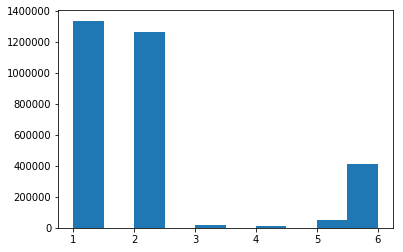

In [10]:
test_dataset = NPM3DGenerator(input_dir = "../Benchmark_MVA/test", train = False)
#model = load_model("trained_{}_{}_{}".format(test_dataset.n_points, test_dataset.n_channels, test_dataset.n_classes))
probas, predictions = test_dataset.predict_point_cloud(model)

plt.hist(predictions)
plt.show()

In [11]:
np.savetxt('MiniDijon9.txt', predictions, fmt='%d')

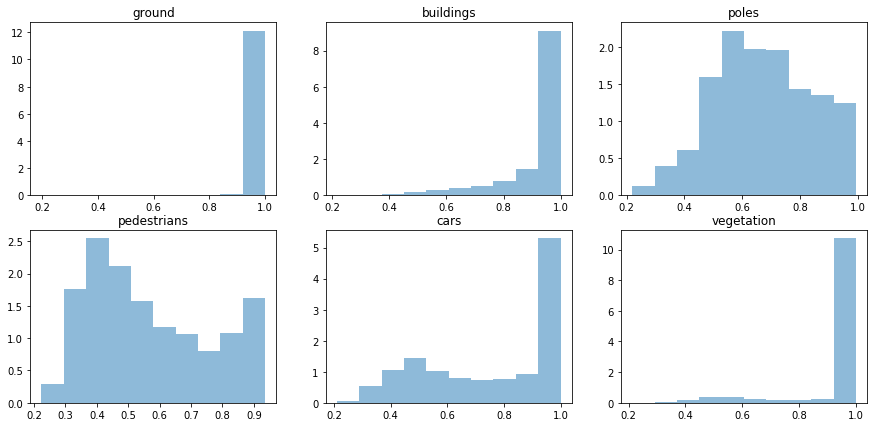

In [23]:
plt.figure(figsize = (15, 7))
for i in range(test_dataset.n_classes):
    plt.subplot(231 + i)
    plt.title(test_dataset.class_dict[i + 1])
    plt.hist(np.max(probas[predictions == 1 + i], axis = -1), normed = True)
plt.show()